In [2]:
import sys
sys.path.append('..')

import h5py
from proSVD import proSVD
import numpy as np
import matplotlib.pyplot as plt
import pdb
from utils.utils import *
from models.data_manager import DataManager

In [83]:
input_dir = '/home/sachinks/Data/processed/octopus'

##################################
def load_input_data(dir):
    np_path = f'{dir}/distal_100Hz_5mA_50ms_221202_134940_000-1.npy'

    data = np.load(np_path)
    data = data[..., ::-1]
    # Convert data to uint8 (assuming grayscale images)
    data = (data).astype('uint8')
    return data

##################################

data = load_input_data(input_dir)


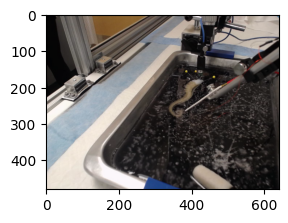

In [18]:
plt.figure(figsize=(3, 3))
plt.imshow(data[0], cmap='gray')

In [88]:
# crop data
data.shape
data = data[:, 140: 140+200, 280:280+200, :]

plt.figure(figsize=(3, 3))
plt.imshow(data[0], cmap='gray')

/home/sachinks/anaconda3/envs/dlc-live/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


In [89]:
data[100:].shape

(630, 200, 200, 3)

In [90]:
# Save gif of video
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

# Sample x and y coordinates for your trajectory
frames = data[100:]
fps = 30

# Create a function to update the plot in each frame
def update(frame):
    plt.clf()  # Clear the previous frame
    plt.imshow(frames[frame], cmap='viridis')  # Display the current frame
    plt.axis('off')  # Turn off axis labels and ticks
    # plt.xlabel('Basis 1')
    # plt.ylabel('Basis 2')
    plt.title(f'Time: {(frame)//fps}s')

# Create an animation
fig, ax = plt.subplots(figsize=(4, 3))  # Adjust the values as needed
ani = FuncAnimation(fig, update, frames=len(frames), repeat=False)

# Save the animation as a GIF
ani.save('octopus_orig.gif', writer='pillow', fps=fps)  # Adjust the frame rate (fps) as needed


In [40]:
PROSVD_K = 4 # no. of dims to reduce to
PROSVD_INIT_FRAME = 100 # No of initial frames used to initialize proSVD

video_metadata = {
    'shape': None,
    'fps': None
}

dm = DataManager()

In [41]:
##################################
def compute_prosvd():
    generator = stream_numpy_array(data)

    frames = []  # for proSVD initialization

    # Iterate over the generator and process each batch
    for index, frame in enumerate(generator):
        frame = frame[0]
        frame = rgb_to_grayscale(frame)

        if index == 0:
            video_metadata['shape'] = frame.shape

        frame = frame.flatten()

        if index < PROSVD_INIT_FRAME:
            frames.append(frame)
            continue

        if index == PROSVD_INIT_FRAME:
            frames = np.array(frames).T
            pro = proSVD(k=PROSVD_K, w_len=1,history=0, decay_alpha=1, trueSVD=True)
            pro.initialize(frames)

        pro.preupdate()
        pro.updateSVD(frame[:, None])
        pro.postupdate()

        dm.add('Q', pro.Q)
        ld = pro.Q.T@frame # loadings
        dm.add('ld', ld)
##################################

compute_prosvd()

Saving proSVD outputs

In [42]:
output_dir = '/home/sachinks/Data/output/octopus'
dm.save(output_dir)

Visualization of proSVD

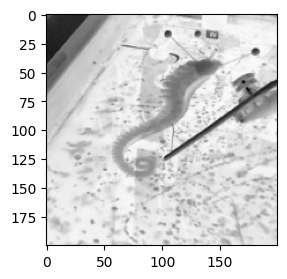

In [44]:
Q = dm.get('Q')
frame_shape = video_metadata['shape']
i = 0
Qi = Q[i]
Qi = Qi.reshape(frame_shape[0], frame_shape[1], PROSVD_K)
plt.figure(figsize=(3, 3))
plt.imshow(Qi[..., 0], cmap='gray')
plt.show()

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from itertools import islice


Q = dm.get('Q')
frame_shape = video_metadata['shape']

# Create a figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2)

# Initialize empty plots for the first frames
images = []

Q0 = Q[0]
Q0 = Q0.reshape(frame_shape[0], frame_shape[1], PROSVD_K)
for i in range(4):
    ax = axs[i // 2, i % 2]
    im = ax.imshow(Q0[..., i], cmap='gray')
    images.append(im)
    ax.set_title(f"Basis {i+1}")  # Add titles to each subplot
    ax.axis('off')

# Super-title for the whole figure
suptitle = plt.suptitle('Time: 0s', fontsize=16, y=0.98)  # Initial frame number

# Function to update the plots with each new frame
def update(frame_idx):
    Qi = Q[frame_idx]
    Qi = Qi.reshape(frame_shape[0], frame_shape[1], PROSVD_K)
    for j in range(4):
        images[j].set_array(Qi[..., j])
    suptitle.set_text(f'Time: {frame_idx//30}s')
    return images

# Create the animation
ani = FuncAnimation(fig, update, frames=len(Q), interval=100, repeat=False)

# Save the animation as a GIF (optional)
ani.save('animation_octo.gif', writer='pillow', fps=30)

# Show the animation (displaying it in Jupyter Notebook or an interactive environment)
plt.show()

/home/sachinks/anaconda3/envs/dlc-live/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


Analysis

In [48]:
data = dm.load(output_dir, ['Q', 'ld'])
Q_full = data['Q']
Q_diff = np.diff(Q_full, axis=0)
Q_norm_diff = np.linalg.norm(Q_diff, axis=1)
Q_norm_diff = np.insert(Q_norm_diff, 0, 0, axis=0)

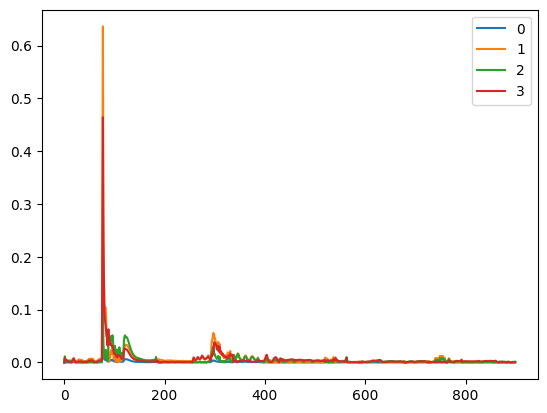

In [63]:
for i in range(PROSVD_K):
    plt.plot(Q_norm_diff[:, i], label=i)
plt.legend()
plt.show()

In [49]:
ld = data['ld']
ld.shape

(630, 4)

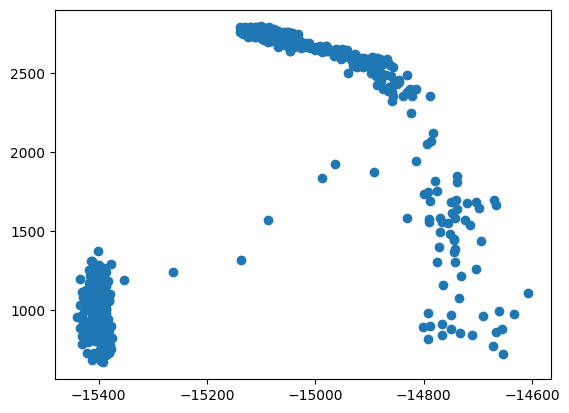

In [53]:
plt.scatter(ld[:, 0], ld[:, 1])

In [64]:
xlim = [ld[:, 0].min(), ld[:, 0].max()]
ylim = [ld[:, 1].min(), ld[:, 1].max()]

(-15439.145706097253, -14606.590598120016)

In [93]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

# Sample x and y coordinates for your trajectory
xlim = [ld[:, 0].min(), ld[:, 0].max()]
ylim = [ld[:, 1].min(), ld[:, 1].max()]

start_f = 0
end_f = ld.shape[0]
fps = 30

x = smooth_data(ld[start_f:end_f, 0])
y = smooth_data(ld[start_f:end_f, 1])

# Create a function to update the plot in each frame
def update(frame):
    plt.clf()  # Clear the previous frame
    plt.plot(x[:frame], y[:frame])  # Plot the trajectory up to the current frame
    plt.xlim(xlim[0], xlim[1])  # Adjust the x-axis limits as needed
    plt.ylim(ylim[0], ylim[1])  # Adjust the y-axis limits as needed
    plt.xlabel('Basis 1')
    plt.ylabel('Basis 2')
    plt.title(f'Time: {(frame+start_f)//fps}s')
    plt.xticks([])  # Hide x ticks
    plt.yticks([])  # Hide y ticks

# Create an animation
fig, ax = plt.subplots(figsize=(4, 3))  # Adjust the values as needed
ani = FuncAnimation(fig, update, frames=len(x), repeat=False)

# Save the animation as a GIF
ani.save('trajectory.gif', writer='pillow', fps=fps)  # Adjust the frame rate (fps) as needed
